## Imports

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
from plotting import *
import json
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_to_pybeh as pb
import scipy
import sys
sys.path.append('/usr/global/Anaconda/2019-10/pkgs')
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')
import statsmodels.api as sm
import matplotlib.animation as animation
error_bars ={'elinewidth':4, 'capsize':5, 'capthick':4}

## Data Download

In [21]:
data = pd.read_csv('data/single_sess_catfr.csv',index_col=0)

In [22]:
finished = []
data['recalled'] = data['recalled'].astype('float')
excl_check = data[data.type == 'WORD'].groupby(['subject', 'session', 'listno'])['recalled'].mean().reset_index()
ugh = []
rav_rej = 0
catfr_rej = 0
# *** Checks if there are multiple lists with 0 correct recalls *** #
for i, df in excl_check.groupby(['subject', 'session']):
    bad = (df.recalled == 0).sum()
    sub, sess = i
    if bad > 1:
        data = data[~((data.subject == sub) & (data.session == sess))]
        ugh.append(sub+'_'+str(sess))
excl_check = excl_check.groupby(['subject', 'session']).mean().reset_index()
data = data[~data.subject.isin(excl_check[excl_check.recalled > 0.95].subject.unique())]
subs = data.subject.unique()
print(len(subs), 'Subjects Accepted')
ugh = np.array(ugh)
print(len(ugh), 'Subjects Rejected')
del ugh

312 Subjects Accepted
145 Subjects Rejected


312

## CatFR

### Set Up DFs

In [35]:
catfr = data[data.phase == 'catFR']
catfr = catfr.query('listno != 0')
catfr = catfr[catfr.list_length == 12]
catfr_enc = catfr[catfr.type == 'WORD']
# bad_annoying = catfr_enc[catfr_enc.duplicated(subset=['subject','session','listno','itemno'])].subject.unique()
catfr_rec = catfr[catfr.type == 'REC_WORD']

### SPC

n = 312


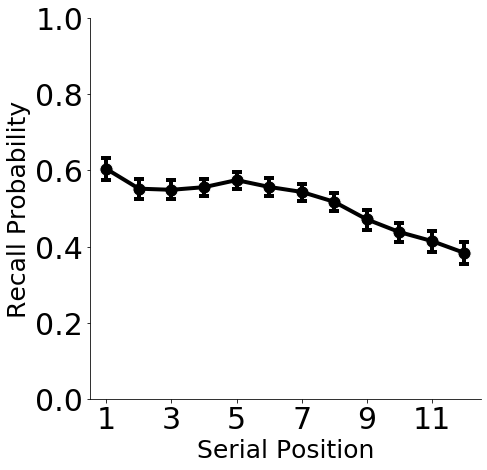

In [36]:
set_axes(xlim = [0.5, 12.5], ylim = [0, 1], xticks = np.arange(1, 13, 2), yticks = np.arange(0, 1.1, .2), fontsize = 30)
catfr_spc = catfr_enc.groupby(['subject', 'serialpos']).recalled.mean().reset_index()
g = sns.lineplot(data = catfr_spc, x = 'serialpos', y = 'recalled', color = 'black', err_style = 'bars', ci = 95, linewidth = 4, err_kws = error_bars)

scatter_catfr_spc = catfr_spc.groupby('serialpos').mean().reset_index()
g = sns.scatterplot(data=scatter_catfr_spc, x ='serialpos', y = 'recalled', s= 175, color = 'black')

_ = plt.xlabel('Serial Position', fontsize = 25)
_ = plt.ylabel('Recall Probability', fontsize = 25)
n = catfr_spc.subject.nunique()
print('n = {}'.format(n))
plt.savefig('figures/catfr_spc.pdf', bbox_inches='tight')

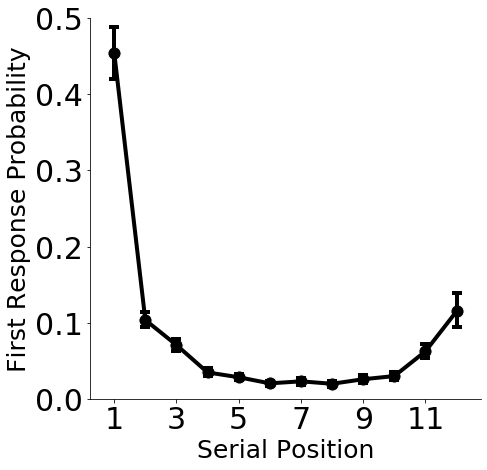

In [37]:
first_recall = []
subs = []
sesss = []
listnos = []
nah = []
for i, df in catfr_rec.groupby(['subject', 'session']):
    sub, sess, = i
    in_ = np.full(12, 0)
    for l, k in df.groupby('listno'):
        subs.append(sub); sesss.append(sess); listnos.append(l)
        pos = int(k.serialpos.iloc[0])
        first_recall.append(pos)
        in_[int(pos) - 1] = 1
    not_in = np.where(in_ == 0)[0]+1
    not_in = pd.DataFrame(dict(first_recall = not_in))
    not_in['subject'] = pd.Series(sub, not_in.index)
    not_in['session'] = pd.Series(sess, not_in.index)
    not_in['listno'] = pd.Series(l, not_in.index)
    nah.append(not_in)
first_recalls = pd.DataFrame({'subject':subs, 'first_recall':first_recall, 'session':sesss, 'listno':listnos})
first_recalls['count'] = pd.Series(1, first_recalls.index)
nah = pd.concat(nah)
nah['count'] = pd.Series(0, index=nah.index)
first_recalls = first_recalls.append(nah)
pfr = (first_recalls.groupby(['first_recall', 'subject', 'session']).sum()).reset_index()
pfr = pfr.groupby(['subject', 'first_recall']).sum().drop(['listno', 'session'],1).reset_index()
pfr = (pfr.set_index(['subject', 'first_recall'])['count']/pfr.groupby(['subject'])['count'].sum()).reset_index()
set_axes(fontsize = 30, ylim=[0,0.5])
sns.lineplot(data = pfr[pfr.first_recall != -1], x = 'first_recall', y = 'count', 
             color = 'black', linewidth=4, ci = 95, err_style='bars',err_kws=error_bars)#, s = 75)
scatter_pfr = pfr.groupby('first_recall').mean().reset_index()
sns.scatterplot(data=scatter_pfr[scatter_pfr.first_recall!=-1],x='first_recall',y='count', color = 'black',s=175)
_ = plt.xticks(np.arange(1,13,2))

_ = plt.ylabel('First Response Probability', fontsize=25)
_ = plt.xlabel('Serial Position',fontsize=25)
plt.savefig('figures/catfr_pfr.pdf', bbox_inches='tight')

### Lag-CRP

In [38]:
num_lags = 6
catfr_crp = catfr.groupby(['subject', 'session']).apply(lambda x: pb.pd_crp(x, itemno_column='itemno', list_index=['subject', 'session', 'listno'], lag_num=num_lags)).reset_index()
n = catfr_crp.subject.nunique()

n = 312


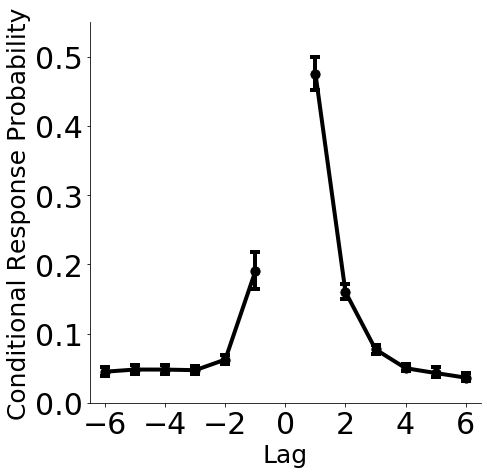

In [39]:
set_axes(xticks = np.arange(-num_lags, num_lags+1, 2), xlim = [-num_lags - 0.5, num_lags + 0.5], yticks = np.arange(0, 0.6, .1), ylim = [0, 0.55], fontsize = 30)
g = sns.lineplot(data = catfr_crp[catfr_crp.lag>0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, color = 'black', linewidth = 4, err_kws=error_bars)
g = sns.lineplot(data = catfr_crp[catfr_crp.lag<0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, color = 'black', linewidth = 4, err_kws=error_bars)
scatter_catfr_crp = catfr_crp.groupby('lag').mean().reset_index()
sns.scatterplot(data = scatter_catfr_crp, x = 'lag', y = 'prob', color = 'black', s=125)
_ = plt.xlabel('Lag', fontsize = 25)
_ = plt.ylabel('Conditional Response Probability', fontsize = 25)

print('n = {}'.format(n))
plt.savefig('figures/catfr_crp.pdf', bbox_inches = 'tight')

### Semantic-CRP

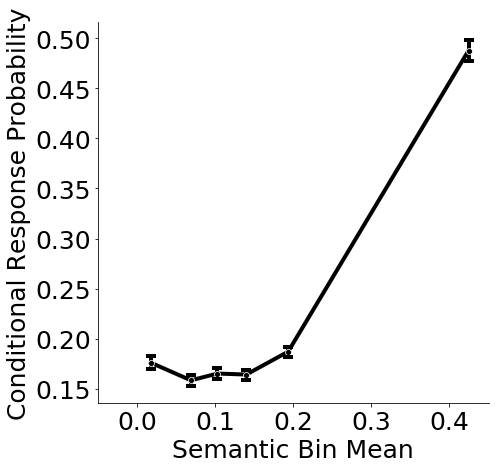

In [20]:
word_evs = catfr.query('type == "WORD"')
rec_evs = catfr.query('type == "REC_WORD"')
#removing repeat presentations
word_evs = word_evs.drop_duplicates(subset=['subject', 'session', 'itemno'], keep='first')

events = word_evs.append(rec_evs)

# replace item nums so they are consistent across subjects
item_col = 'item'
item_num_col = 'itemno'
item_num_df = word_evs.drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df[item_num_col] = item_num_df[item_num_col] + 1
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'itemno_new': -999}, inplace=True)

def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        similarity = keyed_vector.similarity(df[col1].lower(), df[col2].lower())
        return similarity
    except:
        return np.nan

# get all pairs of items
items = item_num_df[item_col].values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=[item_col+'_1', item_col+'_2']).to_frame(index=False)

# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1=item_col+'_1', 
               col2=item_col+'_2', 
               keyed_vector=word2vec_vectors)

sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on=item_col+'_1', right_on=item_col).merge(
    item_num_df, left_on=item_col+'_2', right_on=item_col, suffixes=('_1', '_2'))

sem_sims = pd.pivot_table(sem_sim_num_df, 
                          index=item_num_col+'_1', 
                          columns=item_num_col+'_2', 
                          values='similarity', dropna=False)

n_bins = 6
set_axes(xlim = [-0.05,0.45], xticks = np.arange(-0.1, 1.1, .1), yticks = None, fontsize=25)
catfr_sem_crp = events_new.groupby(['subject']).apply(lambda x: pb.pd_sem_crp(x, itemno_column = 'itemno_new', list_index=['subject', 'session', 'listno'], sem_sims = sem_sims, n_bins=n_bins)).reset_index()
catfr_sem_crp['avg_sem_bin_mean'] = catfr_sem_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
sns.lineplot(data = catfr_sem_crp, x = 'avg_sem_bin_mean', y = 'prob', color = 'black', 
             err_style = 'bars', marker = 'o', linewidth=4, err_kws = error_bars)
_ = plt.xlabel('Semantic Bin Mean')
_ = plt.ylabel('Conditional Response Probability')
plt.savefig('figures/catfr_sem_crp.pdf', bbox_inches='tight')

### Set up DFs

In [32]:
catfr_recall = catfr_enc.groupby(['subject', 'session', 'listno']).recalled.mean().reset_index().groupby(['subject', 'session']).mean().reset_index().drop('listno', axis = 1)
final_catfr = catfr_recall.groupby('subject').mean().reset_index().recalled
np.save('final_catfr', final_catfr)